<a href="https://colab.research.google.com/github/KiavashJamshidi/Hand-gender-prediction/blob/main/hand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
from glob import glob
from pandas import read_csv
from scipy.io import loadmat
from google.colab import drive
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torchvision.models import alexnet
from torch.nn.functional import softmax
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid, save_image
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import ReLU, Linear, Conv2d, Softmax, CrossEntropyLoss

In [2]:
IMG_PATH = "/content/drive/MyDrive/Hands/"
LABEL_PATH = "/content/drive/MyDrive/HandInfo.csv"
OUT_PATH =  "/content/drive/MyDrive/Outs/"

In [3]:
mean1, mean2, mean3 = 240.45/255, 229.64/255, 223.24/255 #low
mean = 245.56/255 #high

In [29]:
std1, std2, std3 = 32.38/255, 48.41/255, 58.85/255 #low
std = 28.11/255 #high

In [5]:
device = torch.device("cuda:0")

In [6]:
def getPartOfMat(mat,status):
  if status == 'low':
    return mat['O'][:,:,:3]
  elif status == 'high':
    return mat['O'][:,:,3]
  elif status == "normal":
    return mat['O']

In [7]:
images = glob(IMG_PATH + '*.jpg')

In [8]:
images.sort()

In [9]:
print(len(images))

11076


In [10]:
details = read_csv(LABEL_PATH)

In [11]:
print(details)

         id  age  gender  ...  aspectOfHand         imageName  irregularities
0         0   27    male  ...  dorsal right  Hand_0000002.jpg               0
1         0   27    male  ...  dorsal right  Hand_0000003.jpg               0
2         0   27    male  ...  dorsal right  Hand_0000004.jpg               0
3         0   27    male  ...  dorsal right  Hand_0000005.jpg               0
4         0   27    male  ...  dorsal right  Hand_0000006.jpg               0
...     ...  ...     ...  ...           ...               ...             ...
11071  1589   22  female  ...   palmar left  Hand_0011740.jpg               0
11072  1589   22  female  ...   palmar left  Hand_0011741.jpg               0
11073  1589   22  female  ...   palmar left  Hand_0011742.jpg               0
11074  1589   22  female  ...   palmar left  Hand_0011743.jpg               0
11075  1589   22  female  ...   palmar left  Hand_0011744.jpg               0

[11076 rows x 9 columns]


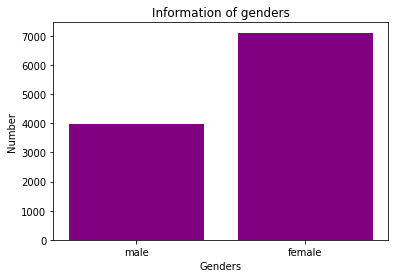

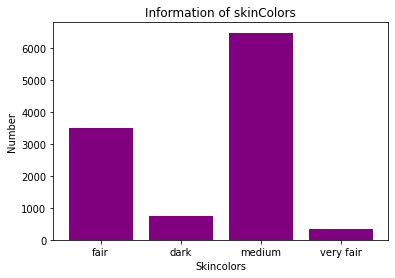

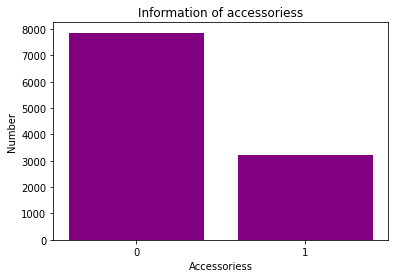

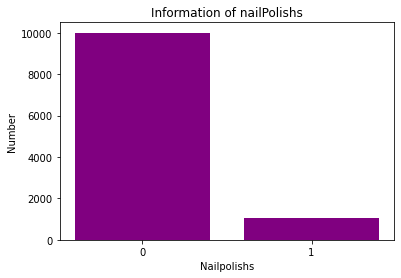

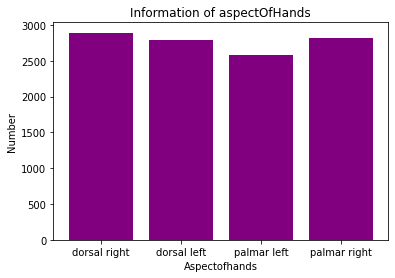

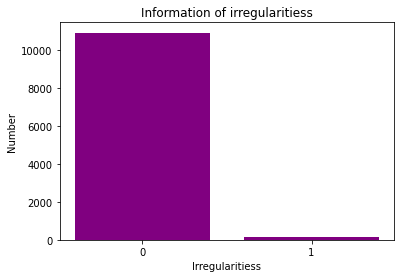

In [12]:
for col in details.columns:
  if col == "id" or col == "imageName" or col == "age": continue
  types = {}
  for row in details[col]:
    if row in types:
      types[row] += 1
      continue
    else:
      types[row] = 0
  plt.bar(range(len(types)), list(types.values()), tick_label=list(types.keys()), color = 'purple')
  plt.title("Information of " + col + "s")
  plt.xlabel(col.capitalize() + "s")
  plt.ylabel('Number')
  plt.show()

In [13]:
outs = glob(OUT_PATH + '*.mat')

In [14]:
outs.sort()

In [15]:
def checkImgOut(images,outs):
  errorFound = len(images) != len(outs)
  for i in range(len(images)):
    a = images[i].split('/')[-1].split('.')[0].split('_')[1]
    b = outs[i].split('/')[-1].split('.')[0].split('_')[1]
    if a != b:
      errorFound = True
  return errorFound

In [16]:
if checkImgOut(images,outs):
  print("There is an error! fix it.")
  input()
else:
  print("Congrats! There is no error.")

Congrats! There is no error.


In [17]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = read_csv(csv_path)
        self.imagesFolder = images_folder
        self.transform = transform
        self.class2index = {"male":0, "female":1}

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, index):
        filename = self.df["imageName"][index]
        label = self.class2index[self.df["gender"][index]]
        image = getPartOfMat(loadmat(self.imagesFolder + "/" + filename[:-3] + "mat"), "low")
        if self.transform is not None:
          image = self.transform(image)
        return image, label
      
    def images(self):
      return glob(self.imagesFolder + "/*.mat")
        

In [18]:
def getMean(outs):
  sum1, sum2, sum3 = 0, 0, 0
  for out in tqdm(outs):
    mat = loadmat(out)
    image = mat['O'][:,:,:3]
    sum1 += image[:,:,0].mean()
    sum2 += image[:,:,1].mean()
    sum3 += image[:,:,2].mean()
  mean1 = sum1 / len(outs)
  mean2 = sum2 / len(outs)
  mean3 = sum3 / len(outs)
  print(mean1, mean2, mean3)
  return mean1, mean2, mean3

In [30]:
def getMean(outs):
  sum = 0
  for out in tqdm(outs):
    mat = loadmat(out)
    image = mat['O'][:,:,:3]
    sum += image[:,:].mean()
  mean = sum / len(outs)
  print(mean)
  return mean

In [21]:
def getStd(outs):
  mean1Tmp, mean2Tmp, mean3Tmp = mean1*255, mean2*255, mean3*255
  sum1, sum2, sum3 = 0, 0, 0
  for out in tqdm(outs):
    mat = loadmat(out)
    image = mat['O'][:,:,:3]
    sum1 += np.power(image[:,:,0] - mean1Tmp, 2).sum()
    sum2 += np.power(image[:,:,1] - mean2Tmp, 2).sum()
    sum3 += np.power(image[:,:,2] - mean3Tmp, 2).sum()
  std1 = np.sqrt(sum1 / len(outs) / 224 / 224)
  std2 = np.sqrt(sum2 / len(outs) / 224 / 224)
  std3 = np.sqrt(sum3 / len(outs) / 224 / 224)
  print(std1, std2, std3)
  return std1, std2, std3

In [22]:
def getStd(outs):
  meanTmp = mean*255
  sum = 0
  for out in tqdm(outs):
    mat = loadmat(out)
    image = mat['O'][:,:,3]
    sum += np.power(image[:,:] - meanTmp, 2).sum()
  std = np.sqrt(sum / len(outs) / 224 / 224)
  print(std)
  return std
std = getStd(outs)

**Part below is for net1! (for low)**

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean1, mean2, mean3), (std1, std2, std3))
])

In [24]:
dataset = CustomDataset(LABEL_PATH, OUT_PATH, transform)
img, label = dataset[100]
img.shape

torch.Size([3, 224, 224])

In [25]:
batch_size = 300
validation_split = 0.7
shuffle_dataset = True
dataset_size = len(dataset)
split = int(np.floor(validation_split * dataset_size))
indices = list(range(dataset_size))

train_indices, test_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainLoader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
testLoader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [26]:
len(trainLoader)

26

In [27]:
len(testLoader)

12

In [ ]:
alexNet = alexnet(pretrained=True)
alexNet = alexNet.to(device)
alexNet.classifier[6].out_features = 2
alexNet.eval()

In [ ]:
state_dict = alexNet.state_dict()
weights = state_dict["features.0.weight"]
bias = state_dict["features.0.bias"]

In [ ]:
criterion = CrossEntropyLoss()
trainAccuracy = []
testAccuracy = []
trainLoss = []
testLoss = []

In [ ]:
# optimizer = optim.SGD(alexNet.parameters(), lr=0.001, momentum=0.9)
# for epoch in range(10):  # loop over the dataset multiple times
#   running_loss = 0.0
#   total, correct = 0, 0
#   # for data in trainLoader:
#   for data in tqdm(trainLoader):

#     inputs, labels = data
#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     optimizer.zero_grad()

#     outputs = alexNet(inputs)
#     loss = criterion(outputs, labels)
#     loss.backward(retain_graph=True)

#     optimizer.step()

#     # print(loss.item())
#     running_loss += loss.item() / len(trainLoader)
#     _, predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     correct += predicted.eq(labels).sum().item()


#   accuracy = 100 * correct / total
#   trainAccuracy.append(accuracy)
#   trainLoss.append(running_loss)
#   print("\nTRAIN: Epoch {}/{}, Accuracy: {:.3f}, Loss: {:.3f}".format(epoch+1,10, accuracy, running_loss))


In [ ]:
# plt.plot(trainAccuracy,'-o')
# # plt.plot(testAccuracy,'-o')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend(['Train','Test'])
# plt.title('Train vs Test Accuracy')
 
# plt.show()

In [ ]:
# plt.plot(trainLoss,'-o')
# # plt.plot(testLoss,'-o')
# plt.xlabel('epoch')
# plt.ylabel('losses')
# plt.legend(['Train','Test'])
# plt.title('Train vs Test Losses')
 
# plt.show()

In [ ]:
# zzz

In [ ]:
# class Net(nn.Module):
#     layers = []
#     def __init__(self, alexNet):
#         super(Net, self).__init__()
#         self.conv2d1 = Conv2d(3, 64, 11, stride=3, padding=0)
#         self.relu1 = alexNet.features[1]
#         self.pool1 = alexNet.features[2]
#         self.conv2d2 = alexNet.features[3]
#         self.relu2 = alexNet.features[4]
#         self.pool2 = alexNet.features[5]
#         self.conv2d3 = alexNet.features[6]
#         self.relu3 = alexNet.features[7]
#         self.conv2d4 = alexNet.features[8]
#         self.relu4 = alexNet.features[9]
#         self.conv2d5 = Conv2d(256, 256, 11, stride=1, padding=1)
#         self.relu5 = alexNet.features[11]
#         self.pool5 = alexNet.features[12]
#         self.fc6 = Linear(256 * 4 * 4, 4096,bias=True)
#         self.relu6 = alexNet.classifier[2]
#         self.drop6 = alexNet.classifier[0]
#         self.fc7 = Linear(4096,2048,bias=True)
#         self.relu7 = alexNet.classifier[2]
#         self.drop7 = alexNet.classifier[0]
#         self.fc8 = Linear(2048,1024,bias=True)
#         self.relu8 = alexNet.classifier[2]
#         self.drop8 = alexNet.classifier[0]
#         self.fc9 = Linear(1024,2,True)
#         # self.cl = Softmax(dim = -1) #error
#         self.layers = [self.conv2d1,self.relu1,self.pool1,
#                        self.conv2d2,self.relu2,self.pool2,
#                        self.conv2d3,self.relu3,
#                        self.conv2d4,self.relu4,
#                        self.conv2d5,self.relu5,self.pool5,
#                        self.fc6,self.relu6,self.drop6,
#                        self.fc7,self.relu7,self.drop7,
#                        self.fc8, self.relu8,self.drop8,
#                        self.fc9]

#     def forward(self, x):
#         x = self.pool1(self.relu1(self.conv2d1(x)))
#         x = self.pool2(self.relu2(self.conv2d2(x)))
#         x = self.relu3(self.conv2d3(x))
#         x = self.relu4(self.conv2d4(x))
#         x = self.pool5(self.relu5(self.conv2d5(x)))

#         x = x.view(-1,256 * 4 * 4)
#         x = self.drop6(self.relu6(self.fc6(x)))
#         x = self.drop7(self.relu7(self.fc7(x)))
#         x = self.drop8(self.relu8(self.fc8(x)))
#         x = self.fc9(x)

#         x = softmax(x, dim = 1)
#         # print(x)
#         return x

In [ ]:
net1 = alexNet
net1.features[0] = Conv2d(3, 64, 11, stride=3, padding=0)
net1.classifier[4].out_features = 2048
net1.classifier[6].in_features = 2048
net1 = net1.to(device)

In [ ]:
alexNet.eval()

In [ ]:
net1.eval()

In [ ]:
learnRate = .001
weight_decay = .1

In [ ]:
opt = SGD(net1.parameters(), lr=0.001, momentum=0.9)

opt1 = Adam([
                {'params': net1.features[0].weight, 'lr': learnRate * 2},
                {'params': net1.features[0].bias, 'lr': learnRate}]
                , weight_decay=weight_decay)
opt2 = Adam([
                {'params': net1.classifier[1].weight, 'lr': learnRate * 2},
                {'params': net1.classifier[1].bias, 'lr': learnRate * 2}]
                , weight_decay=weight_decay)
opt3 = Adam([
                {'params': net1.classifier[4].weight, 'lr': learnRate * 2},
                {'params': net1.classifier[4].bias, 'lr': learnRate * 2}]
                , weight_decay=weight_decay)
opt4 = Adam([
                {'params': net1.classifier[6].weight, 'lr': learnRate * 2},
                {'params': net1.classifier[6].bias, 'lr': learnRate * 2}]
                , weight_decay=weight_decay)


In [39]:
torch.cuda.is_available()

True

In [44]:
def train(epoch,epochs, net1,trainLoader,trainAccuracy,trainLoss,opt1,opt2,opt3,opt4,opt,criterion):
    running_loss = 0
    total, correct = 0, 0
    # for data in trainLoader:
    for data in tqdm(trainLoader ,desc="Train"):

      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      opt1.zero_grad()
      opt2.zero_grad()
      opt3.zero_grad()
      opt4.zero_grad()
      opt.zero_grad()

      outputs = net1(inputs)
      loss = criterion(outputs, labels)
      loss.backward(retain_graph=True)

      opt1.step()
      opt2.step()
      opt3.step()
      opt4.step()
      opt.step()

      running_loss += loss.item() / len(trainLoader)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    # print("weight of first layer is ", net1.layers[0].weight)


    accuracy = 100 * correct / total
    trainAccuracy.append(accuracy)
    trainLoss.append(running_loss)
    print("\nTRAIN: Epoch {}/{}, Accuracy: {:.3f}, Loss: {:.3f}".format(epoch+1,epochs, accuracy, running_loss))


In [45]:
def test(epoch, epochs, net1,testLoader,testAccuracy,testLoss,criterion):    
  running_loss = 0
  total, correct = 0, 0
  with torch.no_grad():
    # for data in testLoader:
    for data in tqdm(testLoader, desc="Test"):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = net1(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item() / len(testLoader)
      
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    testAccuracy.append(accuracy)
    testLoss.append(running_loss)

    print("\nTEST: Epoch {}/{}, Accuracy: {:.3f}, Loss: {:.3f}".format(epoch+1,epochs, accuracy, running_loss))


In [46]:
epochs = 10
criterion = CrossEntropyLoss()
trainAccuracy = []
testAccuracy = []
trainLoss = []
testLoss = []

for epoch in range(epochs):  # loop over the dataset multiple times
  train(epoch, epochs, net1, trainLoader,trainAccuracy,trainLoss,opt1,opt2,opt3,opt4,opt,criterion)
  test(epoch, epochs, net1,testLoader,testAccuracy,testLoss,criterion)

Train: 100%|██████████| 26/26 [23:57<00:00, 55.29s/it]



TRAIN: Epoch 1/10, Accuracy: 59.422, Loss: 4.288


Test: 100%|██████████| 12/12 [09:41<00:00, 48.49s/it]



TEST: Epoch 1/10, Accuracy: 46.494, Loss: 4.104


Train: 100%|██████████| 26/26 [01:03<00:00,  2.43s/it]



TRAIN: Epoch 2/10, Accuracy: 66.271, Loss: 3.223


Test: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it]



TEST: Epoch 2/10, Accuracy: 46.494, Loss: 1.577


Train: 100%|██████████| 26/26 [01:02<00:00,  2.41s/it]



TRAIN: Epoch 3/10, Accuracy: 71.650, Loss: 0.641


Test: 100%|██████████| 12/12 [00:17<00:00,  1.49s/it]



TEST: Epoch 3/10, Accuracy: 46.494, Loss: 0.762


Train: 100%|██████████| 26/26 [01:02<00:00,  2.39s/it]



TRAIN: Epoch 4/10, Accuracy: 70.373, Loss: 0.635


Test: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it]



TEST: Epoch 4/10, Accuracy: 46.494, Loss: 0.748


Train: 100%|██████████| 26/26 [01:02<00:00,  2.42s/it]



TRAIN: Epoch 5/10, Accuracy: 69.367, Loss: 0.626


Test: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it]



TEST: Epoch 5/10, Accuracy: 80.831, Loss: 0.565


Train: 100%|██████████| 26/26 [01:03<00:00,  2.45s/it]



TRAIN: Epoch 6/10, Accuracy: 71.224, Loss: 0.602


Test: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it]



TEST: Epoch 6/10, Accuracy: 66.566, Loss: 0.591


Train: 100%|██████████| 26/26 [01:02<00:00,  2.42s/it]



TRAIN: Epoch 7/10, Accuracy: 73.043, Loss: 0.564


Test: 100%|██████████| 12/12 [00:17<00:00,  1.49s/it]



TEST: Epoch 7/10, Accuracy: 74.692, Loss: 0.548


Train: 100%|██████████| 26/26 [01:02<00:00,  2.41s/it]



TRAIN: Epoch 8/10, Accuracy: 73.455, Loss: 0.555


Test: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it]



TEST: Epoch 8/10, Accuracy: 75.805, Loss: 0.552


Train: 100%|██████████| 26/26 [01:03<00:00,  2.46s/it]



TRAIN: Epoch 9/10, Accuracy: 75.300, Loss: 0.517


Test: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it]



TEST: Epoch 9/10, Accuracy: 73.458, Loss: 0.587


Train: 100%|██████████| 26/26 [01:03<00:00,  2.44s/it]



TRAIN: Epoch 10/10, Accuracy: 74.358, Loss: 0.538


Test: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it]


TEST: Epoch 10/10, Accuracy: 51.098, Loss: 0.714


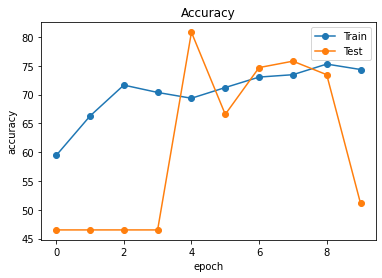

In [47]:
plt.plot(trainAccuracy,'-o')
plt.plot(testAccuracy,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Accuracy')
 
plt.show()

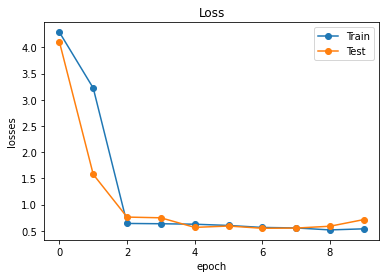

In [48]:
plt.plot(trainLoss,'-o')
plt.plot(testLoss,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Loss')
 
plt.show()

In [ ]:
zzz

**Part below is for net2! (for high)**

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean), (std))])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = read_csv(csv_path)
        self.imagesFolder = images_folder
        self.transform = transform
        self.class2index = {"male":0, "female":1}

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, index):
        filename = self.df["imageName"][index]
        label = self.class2index[self.df["gender"][index]]
        image = getPartOfMat(loadmat(self.imagesFolder + "/" + filename[:-3] + "mat"), "high")
        if self.transform is not None:
          image = self.transform(image)
        return image, label
      
    def images(self):
      return glob(self.imagesFolder + "/*.mat")
        

In [ ]:
dataset = CustomDataset(LABEL_PATH, OUT_PATH, transform)
img, label = dataset[100]
img.shape

In [ ]:
batch_size = 80
validation_split = 0.7
shuffle_dataset = True
dataset_size = len(dataset)
split = int(np.floor(validation_split * dataset_size))
indices = list(range(dataset_size))

train_indices, test_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainLoader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
testLoader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [ ]:
len(trainLoader)

In [ ]:
len(testLoader)

In [ ]:
class Net(nn.Module):
    def __init__(self, alexNet):
        super(Net, self).__init__()
        self.conv2d1 = Conv2d(1, 64, 11, stride=3, padding=0)
        self.relu1 = alexNet.features[1]
        self.pool1 = alexNet.features[2]
        self.conv2d2 = alexNet.features[3]
        self.relu2 = alexNet.features[4]
        self.pool2 = alexNet.features[5]
        self.conv2d3 = alexNet.features[6]
        self.relu3 = alexNet.features[7]
        self.conv2d4 = alexNet.features[8]
        self.relu4 = alexNet.features[9]
        self.conv2d5 = Conv2d(256, 256, 11, stride=1, padding=1)
        self.relu5 = alexNet.features[11]
        self.pool5 = alexNet.features[12]
        self.fc6 = Linear(256 * 4 * 4, 4096,bias=True)
        self.relu6 = alexNet.classifier[2]
        self.drop6 = alexNet.classifier[0]
        self.fc7 = Linear(4096,4096,bias=True)
        self.relu7 = alexNet.classifier[2]
        self.drop7 = alexNet.classifier[0]
        self.fc8 = Linear(4096,2048,bias=True)
        self.relu8 = alexNet.classifier[2]
        self.drop8 = alexNet.classifier[0]
        self.fc9 = Linear(2048,2048,True)
        self.relu9 = alexNet.classifier[2]
        self.drop9 = alexNet.classifier[0]
        self.fc9_ = Linear(2048, 2, True)
        
        self.layers = [self.conv2d1,self.relu1,self.pool1,
                       self.conv2d2,self.relu2,self.pool2,
                       self.conv2d3,self.relu3,
                       self.conv2d4,self.relu4,
                       self.conv2d5,self.relu5,self.pool5,
                       self.fc6,self.relu6,self.drop6,
                       self.fc7,self.relu7,self.drop7,
                       self.fc8,self.relu8,self.drop8,
                       self.fc9,self.relu9,self.drop9,self.fc9_]

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv2d1(x)))
        x = self.pool2(self.relu2(self.conv2d2(x)))
        x = self.relu3(self.conv2d3(x))
        x = self.relu4(self.conv2d4(x))
        x = self.pool5(self.relu5(self.conv2d5(x)))
        x = x.view(-1,256 * 4 * 4)
        x = self.drop6(self.relu6(self.fc6(x)))
        x = self.drop7(self.relu7(self.fc7(x)))
        x = self.drop8(self.relu8(self.fc8(x)))
        x = self.drop9(self.relu9(self.fc9(x)))
        x = self.fc9_(x)
        x = softmax(x, dim = 1)
        return x

In [ ]:
learnRate = .01

In [ ]:
net2 = Net(alexNet).to(device)
net2

In [ ]:
opt1 = Adam([
                {'params': net2.conv2d1.weight, 'lr': learnRate},
                {'params': net2.conv2d1.bias, 'lr': learnRate}]
                , weight_decay=0.8)
opt2 = Adam([
                {'params': net2.fc6.weight, 'lr': learnRate * 2},
                {'params': net2.fc6.bias, 'lr': learnRate * 2}]
                , weight_decay=0.8)
opt3 = Adam([
                {'params': net2.fc7.weight, 'lr': learnRate * 2},
                {'params': net2.fc7.bias, 'lr': learnRate * 2}]
                , weight_decay=0.8)
opt4 = Adam([
                {'params': net2.fc8.weight, 'lr': learnRate * 2},
                {'params': net2.fc8.bias, 'lr': learnRate * 2}]
                , weight_decay=0.8)
opt5 = Adam([
                {'params': net2.fc9.weight, 'lr': learnRate * 2},
                {'params': net2.fc9.bias, 'lr': learnRate * 2}]
                , weight_decay=0.8)

opt6 = Adam([
                {'params': net2.fc9_.weight, 'lr': learnRate * 2},
                {'params': net2.fc9_.bias, 'lr': learnRate * 2}]
                , weight_decay=0.8)

opt = SGD(net2.parameters(), lr=0.0001)

In [ ]:
criterion = CrossEntropyLoss()
trainAccuracy = []
testAccuracy = []
trainLoss = []
testLoss = []

In [ ]:
def train(epoch, epochs, net2, trainLoader,trainAccuracy,trainLoss,opt1,opt2,opt3,opt4,opt5,opt6,opt,criterion)
    running_loss = 0
    total, correct = 0, 0
    for data in trainLoader:
    # for data in tqdm(trainLoader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      opt1.zero_grad()
      opt2.zero_grad()
      opt3.zero_grad()
      opt4.zero_grad()
      opt5.zero_grad()
      opt6.zero_grad()
      opt.zero_grad()

      outputs = net2(inputs)
      loss = criterion(outputs, labels)
      loss.backward()

      opt1.step()
      opt2.step()
      opt3.step()
      opt4.step()
      opt5.step()
      opt6.step()
      opt.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    loss = running_loss / len(trainLoader)
    trainAccuracy.append(accuracy)
    trainLoss.append(loss)

    print("\nTRAIN: Epoch {}/{}, Accuracy: {:.3f}".format(epoch+1,epochs, 100 * correct/total))


In [ ]:
def test(epoch, epochs, net2,testLoader,testAccuracy,testLoss,criterion):    
  running_loss = 0
  total, correct = 0, 0
  with torch.no_grad():
    for data in testLoader:
    # for data in tqdm(testLoader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = net2(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    loss = running_loss / len(testLoader)
    testAccuracy.append(accuracy)
    testLoss.append(loss)

    print("\nTEST: Epoch {}/{}, Accuracy: {:.3f}, Loss: {:.3f}".format(epoch+1,epochs, accuracy,loss))


In [ ]:
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
  train(epoch, epochs, net2, trainLoader,trainAccuracy,trainLoss,opt1,opt2,opt3,opt4,opt5,opt6,opt,criterion)
  test(epoch, epochs, net2,testLoader,testAccuracy,testLoss,criterion)  

In [ ]:
plt.plot(trainAccuracy,'-o')
plt.plot(testAccuracy,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

In [ ]:
plt.plot(trainLoss,'-o')
plt.plot(testLoss,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [ ]:
zzz

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean1, mean2, mean3, mean), (1, 1, 1, 1))])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = read_csv(csv_path)
        self.imagesFolder = images_folder
        self.transform = transform
        self.class2index = {"male":0, "female":1}

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, index):
        filename = self.df["imageName"][index]
        label = self.class2index[self.df["gender"][index]]
        image = getPartOfMat(loadmat(self.imagesFolder + "/" + filename[:-3] + "mat"), "normal")
        if self.transform is not None:
          image = self.transform(image)
        return image, label
      
    def images(self):
      return glob(self.imagesFolder + "/*.mat")
        

In [ ]:
dataset = CustomDataset(LABEL_PATH, OUT_PATH, transform)
img, label = dataset[100]
img.shape

In [ ]:
epochs = 20
batch_size = 80
validation_split = 0.7
shuffle_dataset = True
dataset_size = len(dataset)
split = int(np.floor(validation_split * dataset_size))
indices = list(range(dataset_size))

train_indices, test_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainLoader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
testLoader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [ ]:
len(trainLoader)

In [ ]:
len(testLoader)

In [ ]:
class Net(nn.Module):
    def __init__(self,alexNet, net1, net2):
        super(Net, self).__init__()
        self.skipConv1 = Conv2d(4, 64, 11, stride=3, padding=2)
        self.skipConv2 = Conv2d(4, 64, 11, stride=3, padding=2)
        self.relu1 = net1.layers[1]
        self.pool1 = net1.layers[2]
        self.conv2d2 = net1.layers[3]
        self.relu2 = net1.layers[4]
        self.pool2 = net1.layers[5]
        self.conv2d3 = net1.layers[6]
        self.relu3 = net1.layers[7]
        self.conv2d4 = net1.layers[8]
        self.relu4 = net1.layers[9]
        self.conv2d5 = net1.layers[10]
        self.relu5 = net1.layers[11]
        self.pool5 = net1.layers[12]
        self.fc6 = net1.layers[13]
        self.relu6 = alexNet.classifier[2]
        self.drop6 = alexNet.classifier[0]
        self.fc7 = Linear(4096,4096,bias=True)
        self.relu7 = alexNet.classifier[2]
        self.drop7 = alexNet.classifier[0]
        self.fc8 = Linear(4096,2048,bias=True)
        self.relu8 = alexNet.classifier[2]
        self.drop8 = alexNet.classifier[0]
        self.fc9 = Linear(2048,2,True)
        #
        
        self.relu9 = alexNet.classifier[2]
        self.drop9 = alexNet.classifier[0]
        # self.cl = Softmax(dim = -1) #error

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv2d1(x)))
        x = self.pool2(self.relu2(self.conv2d2(x)))
        x = self.relu3(self.conv2d3(x))
        x = self.relu4(self.conv2d4(x))
        x = self.pool5(self.relu5(self.conv2d5(x)))

        x = x.view(-1,256 * 4 * 4)
        x = self.drop6(self.relu6(self.fc6(x)))
        x = self.drop7(self.relu7(self.fc7(x)))
        x = self.drop8(self.relu8(self.fc8(x)))
        x = self.drop9(self.relu9(self.fc9(x)))

        x = softmax(x, dim = 1)
        # print(x)
        return x

In [ ]:
twoStream = Net(alexNet).to(device)
opt1 = Adam([
                {'params': net1.skipConv1.weight, 'lr': 0},
                {'params': net1.skipConv1.bias, 'lr': 0}]
                , weight_decay=1)
opt2 = Adam([
                {'params': net1.skipConv2.weight, 'lr': 0},
                {'params': net1.skipConv2.bias, 'lr': 0}]
                , weight_decay=1)
# opt2 = Adam([
#                 {'params': net1.fc6.weight, 'lr': 20 * 2},
#                 {'params': net1.fc6.bias, 'lr': 20 * 2}]
#                 , weight_decay=0.8)
# opt3 = Adam([
#                 {'params': net1.fc7.weight, 'lr': 20 * 2},
#                 {'params': net1.fc7.bias, 'lr': 20 * 2}]
#                 , weight_decay=0.8)
# opt4 = Adam([
#                 {'params': net1.fc8.weight, 'lr': 20 * 2},
#                 {'params': net1.fc8.bias, 'lr': 20 * 2}]
#                 , weight_decay=0.8)
# opt5 = Adam([
#                 {'params': net1.fc9.weight, 'lr': 20 * 2},
#                 {'params': net1.fc9.bias, 'lr': 20 * 2}]
#                 , weight_decay=0.8)

# opt = SGD(net1.parameters(), lr=0.0001)


In [ ]:
twoStream

In [ ]:
criterion = CrossEntropyLoss()
trainAccuracy = []
testAccuracy = []
trainLoss = []
testLoss = []

In [ ]:
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    running_loss = 0
    total, correct = 0, 0
    for data in trainLoader:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      opt1.zero_grad()
      opt2.zero_grad()
      opt3.zero_grad()
      opt4.zero_grad()
      opt5.zero_grad()
      opt.zero_grad()

      outputs = net1(inputs)
      loss = criterion(outputs, labels)
      loss.backward()

      opt1.step()
      opt2.step()
      opt3.step()
      opt4.step()
      opt5.step()
      opt.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    loss = running_loss / len(trainLoader)
    trainAccuracy.append(accuracy)
    trainLoss.append(loss)
    print("\nEpoch {}/{}, Accuracy: {:.3f}, Loss: {:.3f}".format(epoch+1,epochs, accuracy,loss))

print('Finished Training')

In [ ]:
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    running_loss = 0
    total, correct = 0, 0
    with torch.no_grad():
      for data in testLoader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        running_loss+=loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

      accuracy = 100 * correct / total
      loss = running_loss / len(testLoader)
      testAccuracy.append(accuracy)
      testLoss.append(loss)

      print("\nEpoch {}/{}, Accuracy: {:.3f}, Loss: {:.3f}".format(epoch+1,num_epochs, accuracy,loss))

print('Finished Testing')

In [ ]:
plt.plot(trainAccuracy,'-o')
plt.plot(testAccuracy,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

In [ ]:
plt.plot(trainLoss,'-o')
plt.plot(testLoss,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Valid Losses')
 
plt.show()